# Загрузка Pandas, чтение данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip3 install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline


import pandas_profiling
from pandas_profiling import ProfileReport
# from pandas_profiling.utils.cache import cache_file
import re
import datetime as dtime
# from datetime import datetime
# import time

In [3]:
# вспомогательные функции
def datetime_to_int(dt):
    return int(dt.strftime("%Y%m%d%H%M%S"))
    
pattern = re.compile('\d+\/\d+\/\d+')

def string_to_dates(str):
  dt = []
  d = pattern.findall(str)
  for current_date in d:
    try:
      dt.append(dtime.datetime.strptime(current_date, '%m/%d/%Y'))
    except ValueError:
      dt.append(dtime.datetime.strptime(current_date, '%d/%m/%Y'))  
  return dt    

def get_city_rn_mean(city):
  return df[df['City'] == city]['Number of Reviews'].mean()

In [16]:
# Чтение данных и замена символов '$' на '!', чтобы исключить ошибке при вызове функции pandas_profiling.ProfileReport(df) 
df = pd.read_csv('/content/drive/My Drive/main_task.xls')
df['Price Range'] = df['Price Range'].apply(lambda x: x.replace('$', '!') if type(x) == type('str') else x)

# EDA данных

In [ ]:
# EDA данных
pandas_profiling.ProfileReport(df)
 

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Очистка и подготовка данных

In [17]:
# Ваш код по очистке данных и генерации новых признаков
# 1. Заполнение пропущенных значений
df['Price Range'].fillna(value = df['Price Range'].mode()[0], inplace=True)
# Пометим незаполненные значения 'Number of Reviews'
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
#  и заполним их средними значениями по городу
for index, row in df.iterrows():
  if (np.isnan(row['Number of Reviews'])):
    df.loc[index, 'Number of Reviews'] = get_city_rn_mean(row['City']) 

In [18]:
# 2. Генерация новых признаков
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('[', '') if type(x) == type('str') else x)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace(']', '') if type(x) == type('str') else x)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.split(',')if type(x) == type('str') else x)
df = df.explode('Cuisine Style')
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.strip() if type(x) == type('str') else x)
df['Cuisine Style'].fillna(value = df['Cuisine Style'].mode()[0], inplace=True) # Заполнение пропущенных значений после добавления строк Cuisine Style 
df['PriceRange'] = df['Price Range'].apply(lambda x: 1 if x == "!" else (3 if x == '!!!!' else 2)).apply(pd.to_numeric)

# using Ranking distribution on Cuisine Style
# decrease Cuisine Style quantity
Cuisine_Style_with_freqs = list(df['Cuisine Style'].value_counts())
top_CuisineStyle_count = int(np.percentile(Cuisine_Style_with_freqs, 90))
all_Cuisine_Style = df['Cuisine Style'].value_counts().index
top_Cuisine_Style = list(all_Cuisine_Style)[:top_CuisineStyle_count]
Cuisine_Style_to_trow_away = list(set(all_Cuisine_Style) - set(top_Cuisine_Style))
df.loc[df['Cuisine Style'].isin(Cuisine_Style_to_trow_away), 'Cuisine Style'] = 'other'

Cuisine_Style_with_freqs = list(df['Cuisine Style'].value_counts())
top_CuisineStyle_count = int(np.percentile(Cuisine_Style_with_freqs, 90))
all_Cuisine_Style = df['Cuisine Style'].value_counts().index
top_Cuisine_Style = list(all_Cuisine_Style)[:top_CuisineStyle_count]
Cuisine_Style_to_trow_away = list(set(all_Cuisine_Style) - set(top_Cuisine_Style))

df.loc[df['Cuisine Style'].isin(Cuisine_Style_to_trow_away), 'Cuisine Style'] = 'other'

In [19]:
# заполняем колонку последней датой Review, а незаполненные значения модой
# и переводим даты в числа
df['Review_dates'] = df['Reviews'].apply(lambda x: string_to_dates(x)) 
df['Review_dates'] = df['Review_dates'].apply(lambda x: np.nan if len(x) == 0 else max(x))
df['Review_dates'].fillna(value = df['Review_dates'].mode()[0], inplace=True)
df['Review_dates'] = pd.to_numeric(df['Review_dates'])
df['Review_dates']

0        1514678400000000000
0        1514678400000000000
0        1514678400000000000
1        1499299200000000000
2        1515369600000000000
                ...         
39998    1499731200000000000
39998    1499731200000000000
39998    1499731200000000000
39998    1499731200000000000
39999    1454198400000000000
Name: Review_dates, Length: 104896, dtype: int64

In [20]:
# создаем dummies 
df = pd.get_dummies(df, columns=[ 'City', 'Cuisine Style',], dummy_na=True)

In [21]:
df.drop(axis=1, columns=['Price Range', 'Reviews', 'URL_TA', 'ID_TA'], inplace=True) # Оставляем только численные колонки   

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [22]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [23]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [24]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [25]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [26]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [27]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# Исходная величина MAE: 0.43633182003968257
# MAE: 0.21718399999999996 замена nan, ценового диапазона на числа и создание dummies по городам
# MAE: 0.10682294844417325 Cuisine Style exploding 0.1076797971323978, 0.10677070622330685, 0.10732420683343499
# MAE: 0.09533557046979863 Review_dates
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.09465012965222691


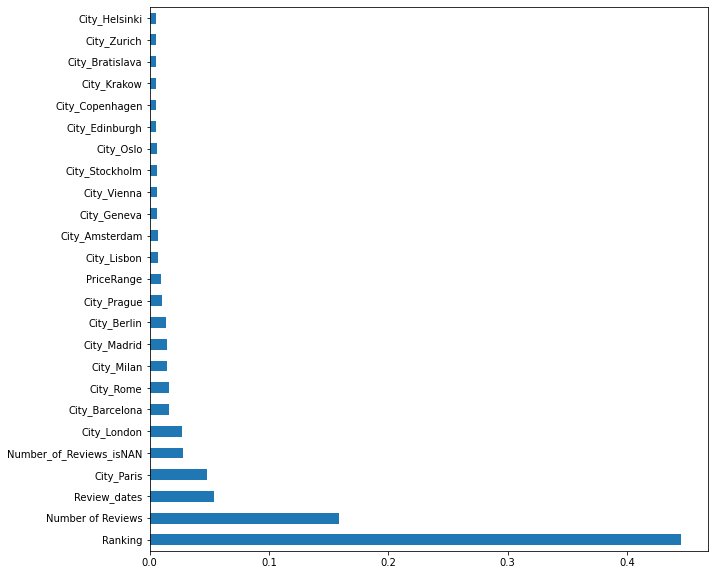

In [28]:
# Cамые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')